# 2.1. Ejercicio

En este ejercicio vamos implementar un perceptrón multicapa (**MLP**) para clasificar imágenes de dígitos.

En concreto clasificaremos el conjunto de datos llamado [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

Para esto vamos a ir siguiendo una serie de pasos, empezando por cargar las librerías necesarias...

Sigue los pasos indicados y completa las líneas marcadas con "**TODO**".


In [36]:
# Importamos las librerías necesarias
import numpy as np

import tensorflow as tf # TODO: Importa la librería de Tensorflow dándole el nombre "tf"

### Paso 1: Cargar los datos en memoria

MNIST es un conjunto con miles de imágenes en escala de grises (en el rango 0-255) de digitos manuscritos. Este dataset se utiliza en numerosos estudios sobre el aprendizaje automático.

In [2]:
# Cargamos los datos...
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


### Paso 2: Visualizar algunas imágenes

Vamos a ver la apariencia que tienen las imágenes de este dataset. Para esto mostraremos algunas muestras escogidas aleatoriamente con su etiqueta o clase correspondiente.

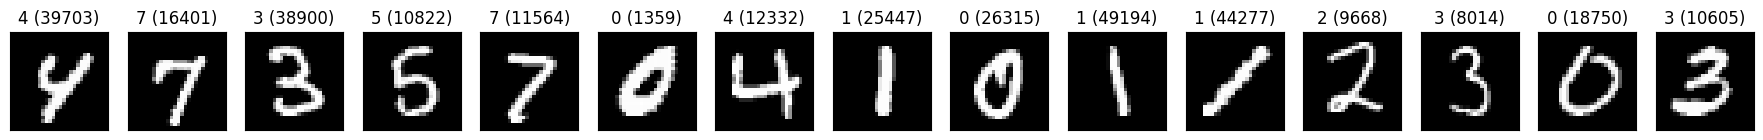

In [3]:
import random
import matplotlib.pyplot as plt

n = 15
index = np.random.randint(len(train_images), size=n)
plt.figure(figsize=(n*1.5, 1.5))
for i in np.arange(n):
    ax = plt.subplot(1,n,i+1)
    ax.set_title('{} ({})'.format(train_labels[index[i]],index[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(train_images[index[i]], cmap='gray')  # Aquí es donde mostramos las imágenes
plt.show()

### Paso 3: Entender el formato de los datos

Las imágenes están almacenadas en un vector 3D de enteros (`train_images`) con las dimensiones (N, 28, 28), donde:

* N es el número de muestras del conjunto de entrenamiento.
* Las otras dos dimensiones "28, 28" corresponden al alto y ancho de la imagen.

Las etiquetas de cada dígito están también almacenadas en un vector (`train_label`) pero de una dimensión (1D). Cada posición de este vector (`train_label[i]`) contiene la clase a la que pertenece la imagen correspondiente  (`train_images[i]`).

Vamos a mostrar estas dimensiones para los conjuntos de entrenamiento y de test:

In [4]:
print(f'Train_images shape: ', train_images.shape) # TODO: Muestra la propiedad "shape" de la variable "train_images"
print(f'Train_labels shape: ', train_labels.shape)  # TODO: Muestra la propiedad "shape" de la variable "train_labels"

print(f'Test_images shape: ', test_images.shape) # TODO: Muestra la propiedad "shape" de la variable "test_images"
print(f'Test_labels shape: ', test_labels.shape) # TODO: Muestra la propiedad "shape" de la variable "test_labels"

Train_images shape:  (60000, 28, 28)
Train_labels shape:  (60000,)
Test_images shape:  (10000, 28, 28)
Test_labels shape:  (10000,)


### Paso 4: Reorganizando las dimensiones

En este ejercicio, como todavía no estamos trabajando con redes Convolucionales, vamos a transformar las imágenes (2D) a un vector plano (1D) que podamos suministrar como entrada una red tipo MLP.

Es decir, en lugar de trabajar con una imagen de 28 x 28, la convertiremos en un vector 1D de 28 x 28 = 784  de longitud en el que estarán alineados en una dimensión todos los píxeles de la imagen.

Además normalizaremos los valores de los píxeles del rango [0, 255] (escala de grises) al rango [0, 1].


In [6]:
TRAINING_SIZE = len(train_images)
TEST_SIZE = len(test_images) # TODO - Obten el tamaño del conjunto de test

# Convertir de (N, 28, 28) a (N, 784)
train_images = np.reshape(train_images, (TRAINING_SIZE, 784))
test_images =  np.reshape(test_images, (TEST_SIZE, 784)) # TODO - redimensiona "test_images" al tamaño "(TEST_SIZE, 784)"

# Convertir un array de unit8 (enteros) en float32 (decimales)
train_images = train_images.astype(np.float32)
test_images =  test_images.astype(np.float32) # TODO - transforma "test_images" a formato decimal

# Normalizar los datos al rango [0,1]
# Como los valores de gris de las imágenes están en el rango [0,255]
# simplemente dividimos por 255
train_images /= 255
test_images  /= 255 # TODO - Normaliza "test_images" entre 0 y 1

print('Train_images shape:', train_images.shape)
print('Test_images shape:', test_images.shape)

Train_images shape: (60000, 784)
Test_images shape: (10000, 784)


### Paso 5: Transformando las etiquetas de clase

Ahora vamos a convetir las etiquetas de las clases, que son enteros (ej. "2"), al formato **[One-Hot](https://en.wikipedia.org/wiki/One-hot)**. Este formado es el adecuado cuando se va a realizar una clasificación para dos o más categorías. En este caso la función de activación a utilizar en la salida de la red deberá ser "**Softmax**".

En este formato cada etiqueta se transforma a un vector en el que todas sus posiciones valdrán 0 excepto la de la clase a representar, que tendrá valor 1. Por ejemplo, la clase "2" se representará mediante el vector "[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"

Para hacer esto utilizaremos la función  [`keras.utils.to_categorical`](https://keras.io/utils/).

In [7]:
NUM_DIGITS =   10 # TODO - Asigna el número de etiquetas de la base de datos

print('La etiqueta del primer dígito del vector es:', train_labels[0] )

train_labels = tf.keras.utils.to_categorical(train_labels, NUM_DIGITS)
test_labels =  tf.keras.utils.to_categorical(test_labels, NUM_DIGITS) # TODO - transforma "test_labels" a formato one-hot

print('Una vez transformado a one-hot esta etiqueta es:', train_labels[0])


La etiqueta del primer dígito del vector es: 5
Una vez transformado a one-hot esta etiqueta es: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### Paso 6: Construir el modelo

Para clasificar esta base de datos vamos a construir un modelo utilizando el [API sequencial de Keras](https://keras.io/models/sequential/). Este modelo estará compuesto por:

* Red de una sola capa oculta.
* La capa oculta tendrá 512 neuronas con activación tipo **Sigmoidea** [activation function](https://keras.io/activations/).
* La capa de salida tendrá 10 neuronas (las 10 posibles clases) con activación tipo  **Softmax** [activation function](https://keras.io/activations/).
* En la primera capa tenemos que indicar el formato de la entrada (dimensiones). En el resto de capas no será necesario especificar la dimensionalidad ya que se calculará automáticamente.
* Para entrenar la red utilizaremos como función de pérdida **categorical crossentropy** [loss function](https://keras.io/losses/) y  **SGD** (*Stocastic Gradiend Descend*) como [optimizador](https://keras.io/optimizers/).

In [9]:
# Construimos la red...
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense( 512, activation='sigmoid', input_shape=(784,)))  # TODO - Asigna 512 neuronas a esta capa
model.add(tf.keras.layers.Dense( 10, activation='softmax'))  # TODO - Asigna el número de etiquetas

# La compilamos...
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# Y mostramos su estructura por pantalla
print(model.summary()) # TODO - imprime el resumen de la red

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
None


### Paso 7: Entrenamiento

A continuación vamos a entrenar el modelo usando su método [fit](https://keras.io/models/sequential/) durante 5 [epocas](https://www.quora.com/What-is-epochs-in-machine-learning).

Durante el entrenamiento se mostrará el progreso, indicando resultado de la función de pérdida después de cada época y el accuracy o acierto obtenido al clasificar los datos.

In [41]:
model.fit(train_images, train_labels, epochs=5, verbose=2)
   # TODO - Llama el método para entrenar la red con "train_images" y "train_labels" durante 5 épocas

Epoch 1/5
1875/1875 - 6s - loss: 0.3685 - accuracy: 0.8960 - 6s/epoch - 3ms/step
Epoch 2/5
1875/1875 - 4s - loss: 0.3540 - accuracy: 0.8993 - 4s/epoch - 2ms/step
Epoch 3/5
1875/1875 - 4s - loss: 0.3427 - accuracy: 0.9023 - 4s/epoch - 2ms/step
Epoch 4/5
1875/1875 - 5s - loss: 0.3339 - accuracy: 0.9046 - 5s/epoch - 2ms/step
Epoch 5/5
1875/1875 - 4s - loss: 0.3267 - accuracy: 0.9064 - 4s/epoch - 2ms/step


### Paso 8: Evaluando el modelo

Una vez entrenado el modelo vamos a evaluarlo con datos que no haya visto durante el entrenamiento.

Es fácil que el modelo tenga una precisión muy alta con los ejemplos que ya ha visto (para los que se ha entrenado), pero ¿qué pasa con los datos que no ha visto antes?

El resultado obtenido con un conjunto de test separado nos permite evaluar si el modelo ha aprendido a generalizar y, por lo tanto, a clasificar nueva información.

In [11]:
loss, accuracy = model.evaluate(test_images, test_labels)    # TODO - Llama al método "evaluate" para evaluar la red con "test_images" y "test_labels"

print('Test aciertos: {:.2f}'.format(accuracy))

313/313 [==============================] - 1s 2ms/step - loss: 0.3589 - accuracy: 0.8999
Test aciertos: 0.90


## Prueba individual de un numero.

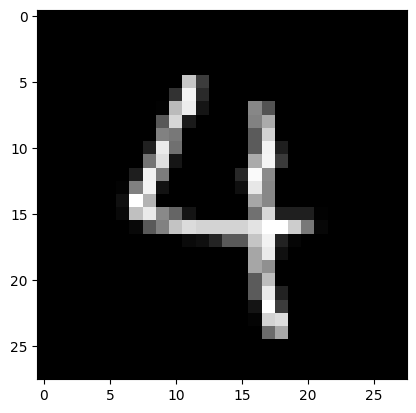

1/1 [==============================] - 0s 21ms/step
El numero es un: 4


In [48]:
x = test_images[24];
x = x.reshape(28, 28)

plt.imshow(x, cmap='gray')
plt.show()

x = x.reshape(1, 784)

prediccion = model.predict(x)
print(f"El numero es un:", np.argmax(prediccion))

